# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-17 09:00:00+09:00,50282.390625,50313.109375,49897.558594,49974.441406,0,0.0,0.0
2025-11-17 09:15:00+09:00,49977.468750,50131.519531,49845.859375,50105.160156,0,0.0,0.0
2025-11-17 09:30:00+09:00,50111.949219,50273.609375,50080.351562,50214.011719,0,0.0,0.0
2025-11-17 09:45:00+09:00,50224.300781,50398.160156,50209.628906,50278.761719,0,0.0,0.0
2025-11-17 10:00:00+09:00,50273.191406,50274.960938,50099.628906,50243.550781,0,0.0,0.0
2025-11-17 10:15:00+09:00,50242.351562,50307.308594,50211.750000,50266.230469,0,0.0,0.0
2025-11-17 10:30:00+09:00,50265.320312,50297.378906,50152.128906,50176.621094,0,0.0,0.0
2025-11-17 10:45:00+09:00,50173.398438,50207.570312,50047.628906,50061.691406,0,0.0,0.0
2025-11-17 11:00:00+09:00,50057.039062,50135.921875,49993.710938,50122.781250,0,0.0,0.0


### ザラ場の時間範囲

In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00").tz_convert('Asia/Tokyo')
dt_start, dt_end

(Timestamp('2025-11-17 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2025-11-17 15:30:00+0900', tz='Asia/Tokyo'))

## 前日終値の取得

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-11-10 00:00:00+09:00    50911.761719
2025-11-11 00:00:00+09:00    50842.929688
2025-11-12 00:00:00+09:00    51063.308594
2025-11-13 00:00:00+09:00    51281.828125
2025-11-14 00:00:00+09:00    50376.531250
2025-11-17 00:00:00+09:00    50267.488281
Name: Close, dtype: float64


Date
2025-11-14 00:00:00+09:00    50376.53125
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-94.14


## ローソク足チャート（小さいサイズ）

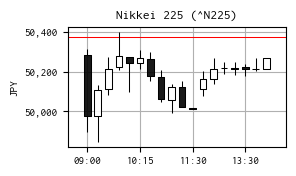

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-14 09:00:00+09:00,154.630005,154.744995,154.595001,154.723007,0,0.0,0.0
2025-11-14 09:15:00+09:00,154.723007,154.738007,154.565994,154.595993,0,0.0,0.0
2025-11-14 09:30:00+09:00,154.589005,154.692001,154.585007,154.684006,0,0.0,0.0
2025-11-14 09:45:00+09:00,154.679993,154.720993,154.559006,154.602997,0,0.0,0.0
2025-11-14 10:00:00+09:00,154.598999,154.684006,154.587006,154.591995,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-17 13:15:00+09:00,154.677002,154.682007,154.630997,154.632004,0,0.0,0.0
2025-11-17 13:30:00+09:00,154.636002,154.671005,154.602997,154.658005,0,0.0,0.0
2025-11-17 13:45:00+09:00,154.662003,154.671005,154.623001,154.628006,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-17 09:00:00+09:00,325.389187,325.587975,322.898848,323.396375
2025-11-17 09:15:00+09:00,323.415965,324.412864,322.564290,324.242287
2025-11-17 09:30:00+09:00,324.214893,325.260804,324.010462,324.875218
2025-11-17 09:45:00+09:00,324.790477,325.914791,324.695597,325.142665
2025-11-17 10:00:00+09:00,325.226539,325.237986,324.103731,325.034788
2025-11-17 10:15:00+09:00,324.984973,325.405138,324.787032,325.139430
2025-11-17 10:30:00+09:00,325.287136,325.494600,324.554629,324.713128
2025-11-17 10:45:00+09:00,324.601947,324.823026,323.788268,323.879247
2025-11-17 11:00:00+09:00,323.715122,324.225251,323.305584,324.140272


### 前日の終値のドル円レートから、前日の終値のドル換算

In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-14 15:15:00+09:00


np.float64(154.5500030517578)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 325.9561970576553


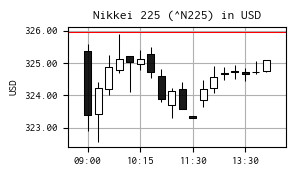

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()